<a href="https://colab.research.google.com/github/SarthakNarayan/DL-and-ML/blob/master/googlecolab/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
from torch import nn
import numpy as np
from torch import optim
from torchvision import models,transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

Features has all the convolution and pooling layers<br/>
Classifier has layers for classification<br/>

In [0]:
vgg19 = models.vgg19(pretrained = True)
# Since we only need the features
vgg19 = vgg19.features
vgg19.cuda()
for param in vgg19.parameters():
    param.requires_grad = False
print(vgg19)
# In this code segment vgg becomes a fixed feature extractor

In [0]:
# Loading the images and converting them to tensors
def image_formatter(path):
    img = Image.open(path)
    show = img.copy()
    plt.imshow(img)
    plt.show()
    # Resize is important because the image may be of different sizes and 
    # we need to scale them down. After that you can take the central part 
    # using CenterCrop
    img_transforms = transforms.Compose([transforms.Resize(400),
                                         transforms.CenterCrop(400),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.485 , 0.456 , 0.406),
                                                               (0.229 , 0.224 , 0.225))
                                        ])
    img = img_transforms(img)
    show = img_transforms(show)
    # removing the alpha channel
    img = img[:3,:,:].unsqueeze(0)
    show = show[:3,:,:].unsqueeze(0)
    print(img.shape)
    return img,show


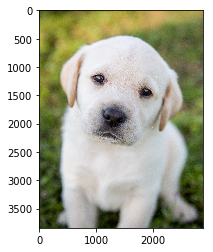

torch.Size([1, 3, 400, 400])


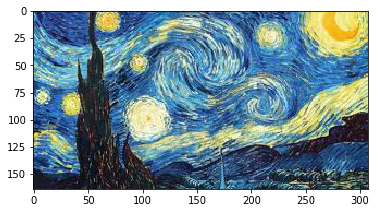

torch.Size([1, 3, 400, 400])


In [5]:
content,view_content = image_formatter("/content/dog.jpg")
style,view_style = image_formatter("/content/style.jfif")
content = content.cuda()
style = style.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


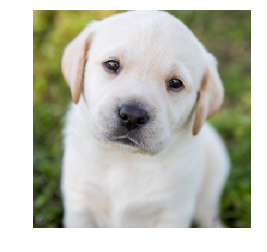

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


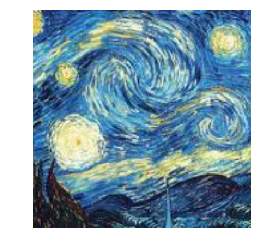

In [8]:
def image_after_transforms(image):
    # Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.
    image = image.cpu().detach().squeeze(0).numpy()
    image = image.transpose(1,2,0)
    # image.reshape wont work
    image = image*np.array((0.229 , 0.224 , 0.225))+np.array((0.485 , 0.456 , 0.406))
    plt.axis('off')
    # Given an interval, values outside the interval are clipped to the interval edges. 
    # For example, if an interval of [0, 1] is specified, values smaller than 0 become 0,
    # and values larger than 1 become 1.
    image.clip(0,1)
    plt.imshow(image)
    plt.show()
    
image_after_transforms(view_content)
image_after_transforms(view_style)

There is a very important difference between reshape and transpose.<br/>
when using pretrained neural networks it is often necessary to adjust the input data dimensions to correspond to what the network has been trained on, e.g. tensors of shape [batch_size, channels, width, height]<br/>
If you do reshape then
![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/basic/transpose_reshape/reshape.png)
Hence the image is not what it used to be<br/>
But with transpose
![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/basic/transpose_reshape/transpose.png)

In [0]:
def gram_matrix(input_tensor):
    _ , d , h , w = input_tensor.size()
    input_tensor = input_tensor.reshape(d,h*w)
    gram_matrix = torch.mm(input_tensor , input_tensor.t())
    return gram_matrix

In [0]:
def get_features(image, model):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    # after maxpool new conv layer

    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # content representation
              '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in enumerate(model.children()):
        x = layer(x)
        # since name is a number
        name = str(name)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
content_features = get_features(content, vgg19)
style_features = get_features(style, vgg19)

# calculate the gram matrices for each layer of our style representation
style_grams = {}
for layer in style_features:
    gram_mat = gram_matrix(style_features[layer])
    style_grams[layer] = gram_mat

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().cuda()
target.requires_grad = True

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
# by increasing style weight you can increase the style in the target image
style_weight = 1e6  # beta

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  23213998.0


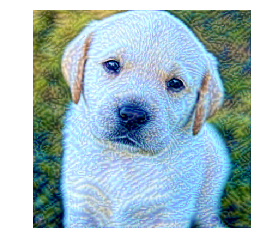

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  6627196.0


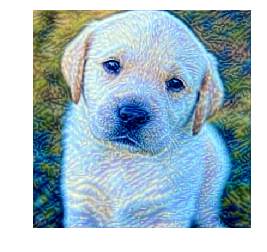

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  2875309.25


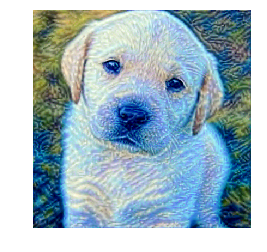

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  1638012.625


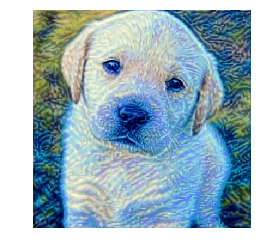

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  1018491.8125


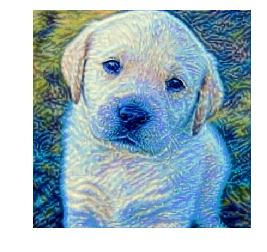

In [13]:
show_every = 400

# Since we want to optimize our image hence we pass it as list to optimizer
# i.e. we are changing our image
optimizer = optim.Adam([target], lr=0.003)
# decide how many iterations to update your image (5000)
steps = 2000  

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg19)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" gram matrix style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        _, d, h, w = target_feature.shape
        
        # get the "style" gram matrix style representation
        style_gram = style_grams[layer]
        
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        image_after_transforms(target)